In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# X  --> Y 
X_dim = 1
Z_dim = 256

# Discriminator Net
X = tf.placeholder(tf.float32, shape=[None, X_dim+2], name='X')

D_W1 = tf.Variable(xavier_init([X_dim+2, 256]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[256]), name='D_b1')

D_W2 = tf.Variable(xavier_init([256, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

G_W0 = tf.Variable(xavier_init([Z_dim, 1024]), name='G_W0')
G_b0 = tf.Variable(tf.zeros(shape=[1024]), name='G_b0')

G_W1 = tf.Variable(xavier_init([1024, X_dim]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[X_dim]), name='G_b1')

G_W2_true = tf.Variable(xavier_init([X_dim, 512]), name='G_W2_true')
G_b2_true = tf.Variable(tf.zeros(shape=[512]), name='G_b2_true')

G_W2_censor = tf.Variable(xavier_init([X_dim, 512]), name='G_W2_censor')
G_b2_censor = tf.Variable(tf.zeros(shape=[512]), name='G_b2_censor')

G_W22_true = tf.Variable(xavier_init([512, 64]), name='G_W22_true')
G_b22_true = tf.Variable(tf.zeros(shape=[64]), name='G_b22_true')

G_W22_censor = tf.Variable(xavier_init([512, 64]), name='G_W22_censor')
G_b22_censor = tf.Variable(tf.zeros(shape=[64]), name='G_b22_censor')

G_W3_true = tf.Variable(xavier_init([64, 1]), name='G_W3_true')
G_b3_true = tf.Variable(tf.zeros(shape=[1]), name='G_b3_true')

G_W3_censor = tf.Variable(xavier_init([64, 1]), name='G_W3_censor')
G_b3_censor = tf.Variable(tf.zeros(shape=[1]), name='G_b3_censor')

theta_G = [G_W0, G_W1, G_W2_true, G_W22_true, G_W3_true, G_W2_censor, G_W22_censor, G_W3_censor, \
           G_b0, G_b1, G_b2_true, G_b22_true, G_b3_true, G_b2_censor, G_b22_censor, G_b3_censor]

In [3]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generate_real(m, d):
    x = np.random.uniform(-1., 1., size=[m, d])
    t = np.sum(x**2, axis=1, keepdims=True)
    c = 0.2*np.ones_like(t)
    y = np.maximum(t,c) # left censoring
    ind = np.argmax([c,t], axis=0) # indicator of censoring
    return np.concatenate((x,y,ind), axis=1)

def generator(z):
    G_x = tf.matmul(tf.nn.relu(tf.matmul(z, G_W0) + G_b0), G_W1) + G_b1
    
    G_h_true = tf.nn.relu(tf.matmul(G_x, G_W2_true) + G_b2_true)
    G_h_censor = tf.nn.relu(tf.matmul(G_x, G_W2_censor) + G_b2_censor)
    
    G_h2_true = tf.nn.relu(tf.matmul(G_h_true, G_W22_true) + G_b22_true)
    G_h2_censor = tf.nn.relu(tf.matmul(G_h_censor, G_W22_censor) + G_b22_censor)
    
    G_t = tf.matmul(G_h2_true, G_W3_true) + G_b3_true
    G_c = tf.matmul(G_h2_censor, G_W3_censor) + G_b3_censor
    
    G_y = tf.maximum(G_t, G_c) # left censoring
    # TODO: how to tell neural network which data is censored?
    # using sigmoid function trick
    G_y_ind = tf.sigmoid(1.0*(G_t - G_c))
    
    G_prob = tf.concat([G_x, G_y, G_y_ind], axis=1)

    return G_prob

def generator2(z):
    G_x = tf.matmul(tf.nn.relu(tf.matmul(z, G_W0) + G_b0), G_W1) + G_b1
    G_h_true = tf.nn.relu(tf.matmul(G_x, G_W2_true) + G_b2_true)
    G_t = tf.matmul(G_h_true, G_W3_true) + G_b3_true
    G_y_ind = tf.ones_like(G_t)
    G_prob = tf.concat([G_x, G_t, G_y_ind], axis=1)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [4]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

In [21]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

clip_D = [p.assign(tf.clip_by_value(p, -0.5, 0.5)) for p in theta_D]

mb_size = 128

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
        1.0, global_step, 5000, 0.9, staircase=True)

D_solver = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

J = 1
K = 1
for it in range(50001):
    for j in range(J):
        X_mb = generate_real(mb_size, X_dim)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        
    for k in range(K):
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if D_loss_curr < 1.0:
        K = 20
        J = 1
    elif G_loss_curr > 2.0:
        K = 20
        J = 1
    else:
        K = 1
        J = 1
        
#     if G_loss_curr < 0.8:
#         J = 10
#         K = 1
        
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.5
G_loss: 193.1

Iter: 1000
D loss: 0.0
G_loss: 2.914e+07

Iter: 2000
D loss: 1.013
G_loss: 1.049e+04

Iter: 3000
D loss: 1.013
G_loss: 4.93e+04

Iter: 4000
D loss: 1.087
G_loss: 1.761

Iter: 5000
D loss: 1.412
G_loss: 0.3635

Iter: 6000
D loss: 1.118
G_loss: 7.524e+04

Iter: 7000
D loss: 0.004277
G_loss: 9.213

Iter: 8000
D loss: 1.054
G_loss: 1.012

Iter: 9000
D loss: 0.9732
G_loss: 3.034e+03

Iter: 10000
D loss: 1.036
G_loss: 1.154

Iter: 11000
D loss: 1.396
G_loss: 0.6884

Iter: 12000
D loss: 1.39
G_loss: 0.808

Iter: 13000
D loss: 1.411
G_loss: 0.8452

Iter: 14000
D loss: 0.7104
G_loss: 125.5

Iter: 15000
D loss: 1.382
G_loss: 2.963e+05

Iter: 16000
D loss: 0.4108
G_loss: 1.343e+03

Iter: 17000
D loss: 1.395
G_loss: 0.603

Iter: 18000
D loss: 1.387
G_loss: 0.6369

Iter: 19000
D loss: 1.386
G_loss: 0.696

Iter: 20000
D loss: 1.41
G_loss: 0.8331

Iter: 21000
D loss: 1.386
G_loss: 0.7356

Iter: 22000
D loss: 1.386
G_loss: 0.6899

Iter: 23000
D loss: 1.4
G_loss: 2.13

In [22]:
# test
G_W2_true_final = G_W2_true.eval(sess)
G_b2_true_final = G_b2_true.eval(sess)
G_W22_true_final = G_W22_true.eval(sess)
G_b22_true_final = G_b22_true.eval(sess)

G_W3_true_final = G_W3_true.eval(sess)
G_b3_true_final = G_b3_true.eval(sess)

G_W2_censor_final = G_W2_censor.eval(sess)
G_b2_censor_final = G_b2_censor.eval(sess)
G_W22_censor_final = G_W22_censor.eval(sess)
G_b22_censor_final = G_b22_censor.eval(sess)

G_W3_censor_final = G_W3_censor.eval(sess)
G_b3_censor_final = G_b3_censor.eval(sess)

In [23]:
import operator
T = generate_real(2000, X_dim)
x = T[:,:-2]
y = T[:,-2:-1]
L = sorted(zip(x,y), key=operator.itemgetter(0))
x, y = zip(*L)

In [24]:
def reLu(x):
    return np.maximum(x,0)

pred = np.dot(reLu(np.dot(reLu(np.dot(x, G_W2_true_final) + G_b2_true_final), G_W22_true_final) \
                   + G_b22_true_final), G_W3_true_final) + G_b3_true_final
pred_c = np.dot(reLu(np.dot(reLu(np.dot(x, G_W2_censor_final) + G_b2_censor_final), G_W22_censor_final) \
                     + G_b22_censor_final), G_W3_censor_final) + G_b3_censor_final

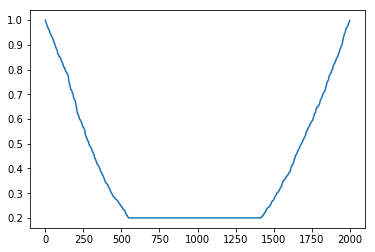

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(y)

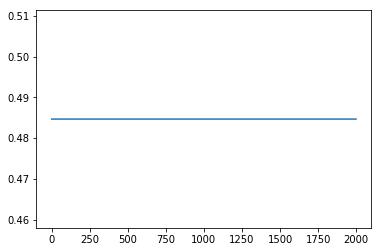

In [26]:
plt.plot(pred)

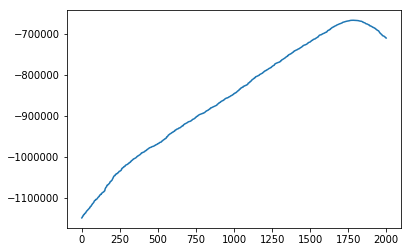

In [27]:
plt.plot(pred_c)

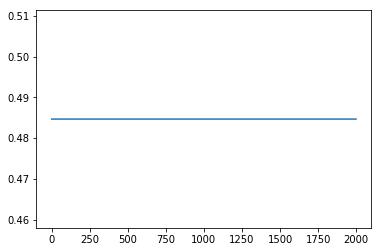

In [28]:
plt.plot(np.maximum(pred, pred_c))

In [24]:
G_W2_true_final = G_W2_true.eval(sess)
G_W2_censor_final = G_W2_censor.eval(sess)
G_b2_true_final = G_b2_true.eval(sess)
G_b2_censor_final = G_b2_censor.eval(sess)

G_W3_true_final = G_W3_true.eval(sess)
G_W3_censor_final = G_W3_censor.eval(sess)
G_b3_true_final = G_b3_true.eval(sess)
G_b3_censor_final = G_b3_censor.eval(sess)

In [25]:
T = generate_real(20, 500)
x = T[:,:-2]
y = T[:,-2:]
y

array([[ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 168.71779885,    1.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 167.        ,    0.        ],
       [ 171.64717848,    1.        ],
       [ 167.        ,    0.        ],
       [ 170.98451881,    1.        ],
       [ 171.01810921,    1.        ],
       [ 167.        ,    0.        ],
       [ 168.28288874,    1.        ],
       [ 168.44981734,    1.        ],
       [ 171.00604524,    1.        ],
       [ 174.96773967,    1.        ]])

In [26]:
def reLu(x):
    return np.maximum(x,0)

In [27]:
np.dot(reLu(np.dot(x, G_W2_true_final) + G_b2_true_final), G_W3_true_final) + G_b3_true_final

array([[  -3166.39379883],
       [   9377.14034659],
       [   4363.44525221],
       [  -2920.04010571],
       [  -3446.74525947],
       [  -3166.39379883],
       [  -3157.03089821],
       [   2287.30149598],
       [  -3050.4801076 ],
       [   7827.00726212],
       [  68247.41605706],
       [  -3145.41691413],
       [   7531.66070081],
       [   5997.82775318],
       [ 118841.49826793],
       [ 121002.12619303],
       [  -2498.54618577],
       [  -3166.39379883],
       [   1453.09201694],
       [  -3110.85289654]])

In [16]:
np.dot(reLu(np.dot(x, G_W2_censor_final) + G_b2_censor_final), G_W3_censor_final) + G_b3_censor_final

array([[  -2368.560813  ],
       [  25156.51526059],
       [  -4070.19691073],
       [    232.06731866],
       [  -3706.66680694],
       [  30055.52632533],
       [   6634.83508854],
       [  -7918.27282903],
       [  26682.33489182],
       [  36477.6404001 ],
       [-138715.83809321],
       [  -5160.89322788],
       [   -611.99924803],
       [  -1641.81348122],
       [  -3440.0113892 ],
       [  44197.95897158],
       [  20199.18530203],
       [ -48621.49225037],
       [   -874.76600672],
       [   7166.54746543]])

In [17]:
G_W2_censor_final

array([[ 41.99728394,  -1.5614028 ,  60.63169861, ...,  67.57331085,
         60.04205322,  68.30484009],
       [  8.93989754,  31.48656273,  12.77091408, ...,  36.04014969,
         47.74028015,  69.70648193],
       [-11.12920761,  -5.83709908, -15.9511652 , ...,  29.95226669,
         35.26268387,   4.27093697],
       ..., 
       [  9.99962711,  -8.98656178,  17.98326874, ..., -19.23607445,
         -6.32428455,  -4.44753933],
       [ 17.94629478,  21.32577324,  85.31217957, ...,  61.66514587,
         47.30208206,  48.70897675],
       [ 20.60667419,  15.96886349,  19.45601273, ...,  35.0466423 ,
         11.98658276,  -1.68000185]], dtype=float32)